# Learning to predict by the methods of temporal differences
## by Sutton, Richard S. (1988)

In [1]:
#! /usr/bin/env python
# __author__ = 'Ning Shi'
# __email__ = 'MrShininnnnn@gmail.com'

In [2]:
# import dependency
import numpy as np
import matplotlib.pyplot as plt

## Problem - Bounded Random Walks

The bounded random walks is an environment where a state sequence is generated by walking randomly to the left or right until a boundary is touched. As the first step in the game, every walk starts from the initial state D. The following step is to move from one state to another on either side. The moving at state B, C, D, E, and F owns the same 50% probability to be right or left. The walking never ends until it enters the terminal state A or G. They are the boundary to complete the entire walk. We call the walk an action sequence as a training sample. For example, DEFEFG is a possible action sequence generated by the game. It starts from the initial state D and ends in the terminated state G.

![Bounded Random Walks](./img/exp_1.png)

## Experiment Setting
A total of 100 training sets, each consisting of 10 sequences, were constructed for use by all learning procedures.

In [3]:
# shared config

# define the random seed to reproduce the same result
random_seed = 0

train_batch = 100
batch_size = 10
train_size = train_batch*batch_size

# the true probabilities for each nonterminal states are 1/6, 1/3, 1/2, 2/3 and 5/6
ideal_pred = np.array([1/6, 1/3, 1/2, 2/3, 5/6], dtype=np.float64).reshape(1, 5)

print('random_seed', random_seed)
print('train_batch', train_batch)
print('batch_size', batch_size)
print('train_size', train_size)
print('ideal_pred', ideal_pred)

random_seed 0
train_batch 100
batch_size 10
train_size 1000
ideal_pred [[0.16666667 0.33333333 0.5        0.66666667 0.83333333]]


## Data

In [4]:
# create a data set where training batch only contains unique action sequences
# define the initial step at state D
start_state = np.array([0, 0, 1, 0, 0], dtype=np.int).reshape(5, 1)

def bounded_random_walks(batch_num, sequence_num, random_seed, sequence_len=float('inf'), unique=False):
    # apply the random seed
    np.random.seed(random_seed)
    # initial the data list
    batch_list = []
    # for loop each batch
    while True:
        # initial the batch list
        sequence_list = []
        # for loop each sequence
        for _ in range(sequence_num):
            # every sequence begins in the center state D
            step_list = [start_state]
            step_position = 2
            # while loop each step
            while True:
                # take a random walk
                step_transition = np.random.choice([-1, 1])
                step_position += step_transition
                # terminate when A or G is reached
                if step_position == -1:
                    step_list.append(0)
                    break
                elif step_position == 5:
                    step_list.append(1)
                    break
                else:
                    # step representation
                    state_vector = np.zeros((5, 1), dtype=np.int)
                    state_vector[step_position] = 1
                    # append step to the sequence
                    step_list.append(state_vector)
            # append sequence to the batch
            sequence_list.append(step_list)
        # append batch to the data list
        if np.mean([len(s) for s in sequence_list]) <= sequence_len:
            if unique:
                if cal_unique_rate(sequence_list) == 1:
                    batch_list.append(sequence_list)
            else:
                batch_list.append(sequence_list)
        if len(batch_list) == batch_num:
            break
    return batch_list
        
# general version
# train_set = bounded_random_walks(train_batch, batch_size, random_seed)

# only save batch containing sequences of length 10 or less
train_set = bounded_random_walks(train_batch, batch_size, random_seed, sequence_len=10)

## TD Learning

In [5]:
def td_learning_op(seq_list, td_lambda, lr, w):
    # initialize the delta w
    delta_w = np.zeros((1, 5))
    # initialize the lambda
    lambda_matrix = np.ones((1, 1))
    # the sequence of steps
    step_list = seq_list[:-1]
    # the outcome of the sequence
    z = seq_list[-1]
    # for loop steps for repeated weight
    for t in range(len(step_list)):
        # get steps so far with t
        t_steps = np.array(step_list[0:t+1]).reshape(t+1, -1)
        # terminal
        if t == len(step_list) - 1:
            cur_step = step_list[-1]
            delta_p = z - np.dot(w, cur_step)
        # non-terminal
        else:
            delta_p = np.dot(w, step_list[t+1]) - np.dot(w, step_list[t])
        # calculate the delta w
        delta_w += lr * delta_p * np.sum(np.dot(lambda_matrix.T, t_steps), axis=0)
        # an exponential weighting with recency
        lambda_matrix = np.concatenate(((lambda_matrix*td_lambda), np.ones((1, 1))))
        
    return delta_w

## Evaluation
The evaluation indicator is the root mean squared (RMS) error between the procedure's asymptotic predictions using that training set and the ideal predictions.

In [6]:
def cal_rmse(pred, true):
    return np.sqrt(np.mean((pred-true)**2))

## Figure 3

In [7]:
def gen_fig_3(train_set, learning_rate, convergence_criteria, lambda_list): 
    # to save results of each lambda
    lambda_error_list = []
    # for loop each lambda value
    for lambda_val in lambda_list:
        print('Train of Lambda {}'.format(lambda_val))
        # to save results of each batch
        batch_error_list = []
        # for loop batches
        for batch in train_set:
            # initialize w
            w = np.random.rand(1, 5)
            # start weight updating
            while True:
            # for loop sequences
                delta_w = np.sum([td_learning_op(seq, lambda_val, learning_rate, w) for seq in batch], axis=0)
                if np.linalg.norm(delta_w) > convergence_criteria:
                    w += delta_w
                else:
                    break
            # evaluation 
            error = cal_rmse(w, ideal_pred)
            batch_error_list.append(error)
        # averaged measure over 100 training sets
        lambda_error_list.append(np.mean(batch_error_list))
    return lambda_error_list

In [8]:
# config for figure 3
learning_rate = 0.01
convergence_criteria = 0.001
lambda_list = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
lambda_error_list = gen_fig_3(train_set, learning_rate, convergence_criteria, lambda_list)

Train of Lambda 0
Train of Lambda 0.1
Train of Lambda 0.3
Train of Lambda 0.5
Train of Lambda 0.7
Train of Lambda 0.9
Train of Lambda 1


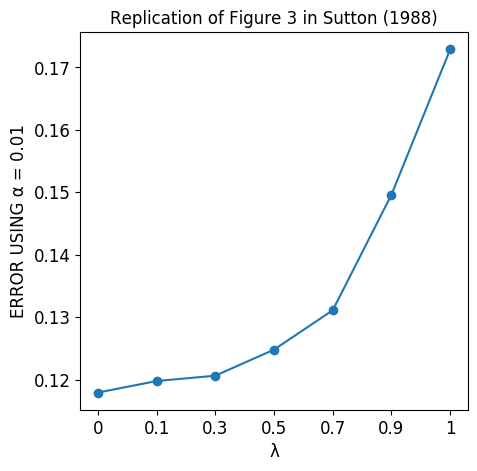

In [9]:
plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(lambda_error_list, marker='o')
plt.ylabel('ERROR USING α = {}'.format(learning_rate), fontsize=12)
plt.xlabel('λ', fontsize=12)
plt.xticks(range(len(lambda_error_list)), 
           [str(l) for l in lambda_list], fontsize=12)
plt.yticks(fontsize=12)
plt.title('Replication of Figure 3 in Sutton (1988)', fontsize=12)
plt.show()

## Figure 4

In [10]:
def gen_fig_4(train_set, lambda_list, lr_list): 
    # record results of various lambda
    evaluation_history_dict = dict()
    # for loop lambda from [0.0, 0.3, 0.8, 1.0]
    for lambda_val in lambda_list:
        print('Train of Lambda {}'.format(np.round(lambda_val, decimals=2)))
        # save results of each lambda
        lambda_error_list = []
        # for loop alpha as the learning rate
        for learning_rate in lr_list:
            # save results of each batch
            batch_error_list = []
            # for loop training set
            for batch in train_set:
                # initialize w
                w = np.ones((1, 5))*0.5
                # for loop sequences
                for seq in batch:
                    # update weight after each sequence
                    w += td_learning_op(seq, lambda_val, learning_rate, w)
                # evaluation after each batch
                error = cal_rmse(w, ideal_pred)
                batch_error_list.append(error)
            lambda_error_list.append(np.mean(batch_error_list))
        evaluation_history_dict[lambda_val] = lambda_error_list
    return evaluation_history_dict

In [11]:
# config for figure 4
lambda_list = [0.0, 0.3, 0.8, 1.0]
lr_list = np.arange(13)*0.05
print('Lambda Value List (λ)', lambda_list)
print('Learning Rate List (α)', lr_list)
evaluation_history_dict = gen_fig_4(train_set, lambda_list, lr_list)

Lambda Value List (λ) [0.0, 0.3, 0.8, 1.0]
Learning Rate List (α) [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6 ]
Train of Lambda 0.0
Train of Lambda 0.3
Train of Lambda 0.8
Train of Lambda 1.0


In [12]:
# cut off the y axis at error 0.7 for Lambda 1.0
for i in range(len(evaluation_history_dict[1.0])):
    if evaluation_history_dict[1.0][i] > 0.7:
        break
evaluation_history_dict[1.0] = evaluation_history_dict[1.0][:i+1]

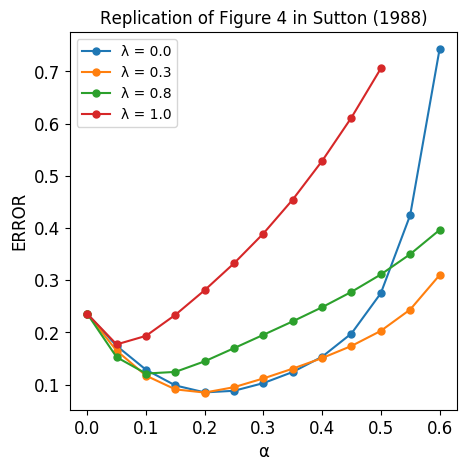

In [13]:
plt.subplots(figsize = (5, 5), dpi=100)
for lambda_val in lambda_list:
    plt.plot(evaluation_history_dict[lambda_val], 
            label='λ = {}'.format(np.round(lambda_val, decimals=2)), 
            marker='o', 
            ms=5)
plt.xlabel('α', fontsize=12)
plt.ylabel('ERROR', fontsize=12)
plt.xticks([0, 2, 4, 6, 8, 10, 12], 
           np.array([str(np.round(lr, decimals=2)) for lr in lr_list])[[0, 2, 4, 6, 8, 10, 12]], 
           fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best')
plt.title('Replication of Figure 4 in Sutton (1988)', fontsize=12)
plt.show()

## Figure 5

In [14]:
def gen_fig_5(train_set, lambda_list, lr_list): 
    # record results of various lambda
    evaluation_history_dict = dict()
    # for loop each lambda value
    for lambda_val in lambda_list:
        print('Train of Lambda {}'.format(np.round(lambda_val, decimals=2)))
        # to save results of each lambda
        lambda_error_list = []
        for learning_rate in lr_list:
            # to save results of each batch
            batch_error_list = []
            # for loop batches
            for batch in train_set:
                # initialize w
                w = np.ones((1, 5))*0.5
                # start weight updating
                for seq in batch:
                    # update weight after each sequence
                    w += td_learning_op(seq, lambda_val, learning_rate, w)
                # evaluation 
                error = cal_rmse(w, ideal_pred)
                batch_error_list.append(error)
            # averaged measure over 100 training sets
            lambda_error_list.append(np.mean(batch_error_list))
        evaluation_history_dict[lambda_val] = lambda_error_list
    return evaluation_history_dict

In [15]:
# config for figure 5
lambda_list = np.arange(0, 1.1, 0.1)
lr_list = np.arange(13)*0.05
evaluation_history_dict = gen_fig_5(train_set, lambda_list, lr_list)

# find the best alpha for each lambda
best_lr_list = []
for lambda_val in evaluation_history_dict:
    best_lr_index = np.argmin(evaluation_history_dict[lambda_val])
    best_lr = lr_list[best_lr_index]
    best_lr_list.append(np.round(best_lr, decimals=2))

print('Best Learning Rates:', best_lr_list)

Train of Lambda 0.0
Train of Lambda 0.1
Train of Lambda 0.2
Train of Lambda 0.3
Train of Lambda 0.4
Train of Lambda 0.5
Train of Lambda 0.6
Train of Lambda 0.7
Train of Lambda 0.8
Train of Lambda 0.9
Train of Lambda 1.0
Best Learning Rates: [0.2, 0.2, 0.2, 0.2, 0.2, 0.15, 0.15, 0.15, 0.1, 0.1, 0.05]


In [16]:
# to save results of each lambda
lambda_error_list = []
# for loop each lambda value
for lambda_val, learning_rate in zip(np.round(lambda_list, decimals=2), best_lr_list):
    print('Train of Lambda {} Alpha {}'.format(lambda_val, learning_rate))
    # to save results of each batch
    batch_error_list = []
    # for loop batches
    for batch in train_set:
        # initialize w
        w = np.ones((1, 5))*0.5
        # start weight updating
        for seq in batch:
            # update weight after each sequence
            w += td_learning_op(seq, lambda_val, learning_rate, w)
        # evaluation 
        error = cal_rmse(w, ideal_pred)
        batch_error_list.append(error)
    # averaged measure over 100 training sets
    lambda_error_list.append(np.mean(batch_error_list))

Train of Lambda 0.0 Alpha 0.2
Train of Lambda 0.1 Alpha 0.2
Train of Lambda 0.2 Alpha 0.2
Train of Lambda 0.3 Alpha 0.2
Train of Lambda 0.4 Alpha 0.2
Train of Lambda 0.5 Alpha 0.15
Train of Lambda 0.6 Alpha 0.15
Train of Lambda 0.7 Alpha 0.15
Train of Lambda 0.8 Alpha 0.1
Train of Lambda 0.9 Alpha 0.1
Train of Lambda 1.0 Alpha 0.05


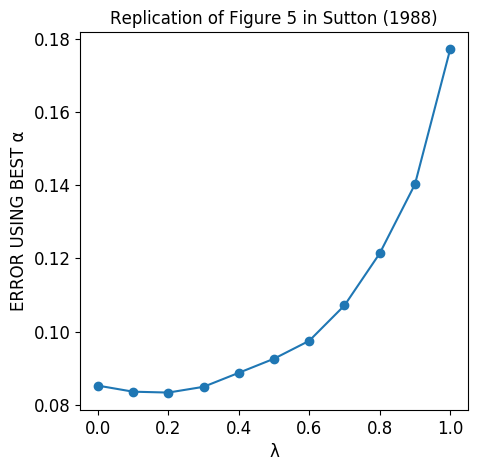

In [17]:
plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(lambda_error_list, marker='o')
plt.ylabel('ERROR USING BEST α', fontsize=12)
plt.xlabel('λ', fontsize=12)
plt.xticks([0, 2, 4, 6, 8, 10], 
           np.round(np.array(lambda_list), decimals=2)[[0, 2, 4, 6, 8, 10]], 
          fontsize=12)
plt.yticks(fontsize=12)
plt.title('Replication of Figure 5 in Sutton (1988)', fontsize=12)
plt.show()

In [18]:
print('The best lambda value is {}'.format(lambda_list[np.argmin(lambda_error_list)]))

The best lambda value is 0.2


# Exploration - Remove Duplicates
The idea of exploration section is to remove duplicated training samples.

In [19]:
# calculate the unique ratio of a training set
def cal_unique_rate(batch):
    unique_batch = []
    for seq in batch:
        act_seq = [np.argmax(a) for a in seq[:-1]]
        if act_seq not in unique_batch:
            unique_batch.append(act_seq)
    return len(unique_batch)/len(batch)

In [20]:
# calculagte the repeated action sequence
unique_ratio_list = []
for batch in train_set:
    unique_ratio = cal_unique_rate(batch)
    unique_ratio_list.append(unique_ratio)

print(np.mean(unique_ratio_list))

0.8280000000000001


In [21]:
# generate data with batches only have unique action sequences     
train_set = bounded_random_walks(train_batch, batch_size, random_seed, sequence_len=10, unique=True)

In [22]:
# calculagte the repeated action sequence
unique_ratio_list = []
for batch in train_set:
    unique_ratio = cal_unique_rate(batch)
    unique_ratio_list.append(unique_ratio)

print(np.mean(unique_ratio_list))

1.0


## FIgure 3

In [23]:
# config for figure 3
learning_rate = 0.01
convergence_criteria = 0.001
lambda_list = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
lambda_error_list = gen_fig_3(train_set, learning_rate, convergence_criteria, lambda_list)

Train of Lambda 0
Train of Lambda 0.1
Train of Lambda 0.3
Train of Lambda 0.5
Train of Lambda 0.7
Train of Lambda 0.9
Train of Lambda 1


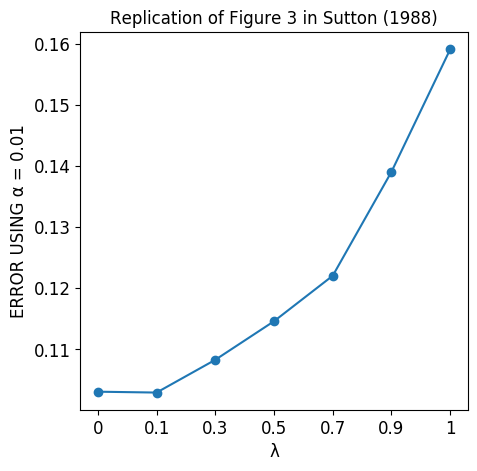

In [24]:
plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(lambda_error_list, marker='o')
plt.ylabel('ERROR USING α = {}'.format(learning_rate), fontsize=12)
plt.xlabel('λ', fontsize=12)
plt.xticks(range(len(lambda_error_list)), 
           [str(l) for l in lambda_list], fontsize=12)
plt.yticks(fontsize=12)
plt.title('Replication of Figure 3 in Sutton (1988)', fontsize=12)
plt.show()

## Figure 4

In [25]:
# config for figure 4
lambda_list = [0.0, 0.3, 0.8, 1.0]
lr_list = np.arange(13)*0.05
print('Lambda Value List (λ)', lambda_list)
print('Learning Rate List (α)', lr_list)
evaluation_history_dict = gen_fig_4(train_set, lambda_list, lr_list)

Lambda Value List (λ) [0.0, 0.3, 0.8, 1.0]
Learning Rate List (α) [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6 ]
Train of Lambda 0.0
Train of Lambda 0.3
Train of Lambda 0.8
Train of Lambda 1.0


In [26]:
# cut off the y axis at error 0.7 for Lambda 1.0
for i in range(len(evaluation_history_dict[1.0])):
    if evaluation_history_dict[1.0][i] > 0.7:
        break
evaluation_history_dict[1.0] = evaluation_history_dict[1.0][:i+1]

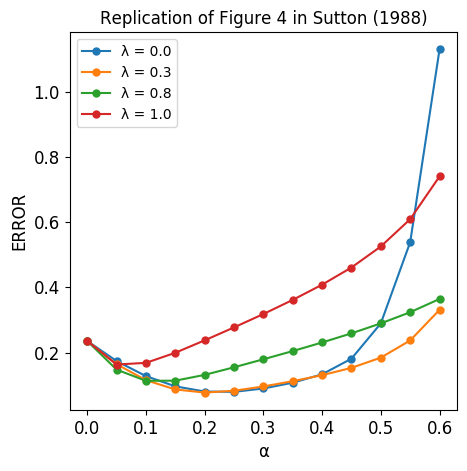

In [27]:
plt.subplots(figsize = (5, 5), dpi=100)
for lambda_val in lambda_list:
    plt.plot(evaluation_history_dict[lambda_val], 
            label='λ = {}'.format(np.round(lambda_val, decimals=2)), 
            marker='o', 
            ms=5)
plt.xlabel('α', fontsize=12)
plt.ylabel('ERROR', fontsize=12)
plt.xticks([0, 2, 4, 6, 8, 10, 12], 
           np.array([str(np.round(lr, decimals=2)) for lr in lr_list])[[0, 2, 4, 6, 8, 10, 12]], 
           fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best')
plt.title('Replication of Figure 4 in Sutton (1988)', fontsize=12)
plt.show()

## Figure 5

In [28]:
# config for figure 5
lambda_list = np.arange(0, 1.1, 0.1)
lr_list = np.arange(13)*0.05
evaluation_history_dict = gen_fig_5(train_set, lambda_list, lr_list)

# find the best alpha for each lambda
best_lr_list = []
for lambda_val in evaluation_history_dict:
    best_lr_index = np.argmin(evaluation_history_dict[lambda_val])
    best_lr = lr_list[best_lr_index]
    best_lr_list.append(np.round(best_lr, decimals=2))

print('Best Learning Rates:', best_lr_list)

Train of Lambda 0.0
Train of Lambda 0.1
Train of Lambda 0.2
Train of Lambda 0.3
Train of Lambda 0.4
Train of Lambda 0.5
Train of Lambda 0.6
Train of Lambda 0.7
Train of Lambda 0.8
Train of Lambda 0.9
Train of Lambda 1.0
Best Learning Rates: [0.25, 0.2, 0.2, 0.2, 0.2, 0.2, 0.15, 0.15, 0.1, 0.1, 0.05]


In [29]:
# to save results of each lambda
lambda_error_list = []
# for loop each lambda value
for lambda_val, learning_rate in zip(np.round(lambda_list, decimals=2), best_lr_list):
    print('Train of Lambda {} Alpha {}'.format(lambda_val, learning_rate))
    # to save results of each batch
    batch_error_list = []
    # for loop batches
    for batch in train_set:
        # initialize w
        w = np.ones((1, 5))*0.5
        # start weight updating
        for seq in batch:
            # update weight after each sequence
            w += td_learning_op(seq, lambda_val, learning_rate, w)
        # evaluation 
        error = cal_rmse(w, ideal_pred)
        batch_error_list.append(error)
    # averaged measure over 100 training sets
    lambda_error_list.append(np.mean(batch_error_list))

Train of Lambda 0.0 Alpha 0.25
Train of Lambda 0.1 Alpha 0.2
Train of Lambda 0.2 Alpha 0.2
Train of Lambda 0.3 Alpha 0.2
Train of Lambda 0.4 Alpha 0.2
Train of Lambda 0.5 Alpha 0.2
Train of Lambda 0.6 Alpha 0.15
Train of Lambda 0.7 Alpha 0.15
Train of Lambda 0.8 Alpha 0.1
Train of Lambda 0.9 Alpha 0.1
Train of Lambda 1.0 Alpha 0.05


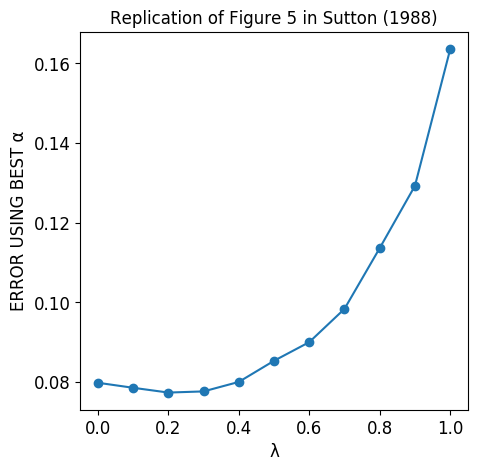

In [30]:
plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(lambda_error_list, marker='o')
plt.ylabel('ERROR USING BEST α', fontsize=12)
plt.xlabel('λ', fontsize=12)
plt.xticks([0, 2, 4, 6, 8, 10], 
           np.round(np.array(lambda_list), decimals=2)[[0, 2, 4, 6, 8, 10]], 
          fontsize=12)
plt.yticks(fontsize=12)
plt.title('Replication of Figure 5 in Sutton (1988)', fontsize=12)
plt.show()

In [31]:
print('The best lambda value is {}'.format(lambda_list[np.argmin(lambda_error_list)]))

The best lambda value is 0.2
